In [1]:
!pip install -q kaggle 

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle competitions download -c gan-getting-started

 96% 353M/367M [00:02<00:00, 153MB/s]
100% 367M/367M [00:02<00:00, 149MB/s]


In [5]:
!unzip gan-getting-started.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e71a4094.jpg  
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391

# learning by copying😜
> ~https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial~
> https://www.kaggle.com/code/peakwhisky/monet-dcgan




In [6]:
# !pip3 install tensorflow_addons

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import glob
import time

In [8]:
image_feature_description = {
    
    'image_name':tf.io.FixedLenFeature([], tf.string),
    'image':tf.io.FixedLenFeature([], tf.string),
    'target':tf.io.FixedLenFeature([], tf.string)
}


In [9]:
IMG_SIZE = [256,256]
def decode_image(image):
  image = tf.image.decode_jpeg(image,channels=3)
  image = (tf.cast(image,tf.float32)/127.5)-1 
  image = tf.reshape(image,[*IMG_SIZE,3])
  return image

def parse_image_function(example_proto):
  example= tf.io.parse_single_example(example_proto, image_feature_description)
  image = decode_image(example['image'])
  return image

In [10]:
AUTOTUNE = tf.data.AUTOTUNE 
def load_data(filename):
  raw_ds = tf.data.TFRecordDataset(filename)
  raw_ds = raw_ds.map(parse_image_function,num_parallel_calls=AUTOTUNE)
  return raw_ds 



In [11]:
import os 
MONET_FILENAMES = os.listdir('monet_tfrec')
print(len(MONET_FILENAMES))

5


In [12]:
MONET_FILENAMES

['monet16-60.tfrec',
 'monet12-60.tfrec',
 'monet00-60.tfrec',
 'monet08-60.tfrec',
 'monet04-60.tfrec']

In [13]:
monet_tfrec ='monet_tfrec'
MONET_PATHS= [os.path.join(monet_tfrec,filename) for filename in MONET_FILENAMES]

In [14]:
MONET_PATHS

['monet_tfrec/monet16-60.tfrec',
 'monet_tfrec/monet12-60.tfrec',
 'monet_tfrec/monet00-60.tfrec',
 'monet_tfrec/monet08-60.tfrec',
 'monet_tfrec/monet04-60.tfrec']

In [15]:
monet_ds = load_data(MONET_PATHS).batch(1)

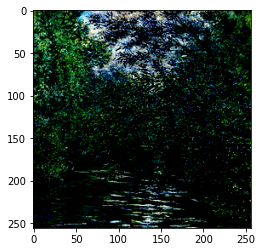

In [16]:
sample = next(iter(monet_ds))
plt.imshow(sample[0])
plt.show()

In [17]:
sample.shape

TensorShape([1, 256, 256, 3])

(28,28) for tutorial DCGAN checking 

In [18]:
IMG_SIZE = 28 
resize = keras.layers.Resizing(IMG_SIZE,IMG_SIZE)
tutorial_ds = monet_ds.map(lambda x:resize(x))

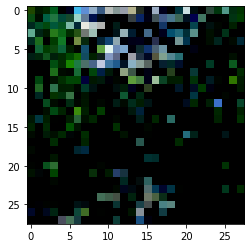

In [19]:
sample = next(iter(tutorial_ds))
plt.imshow(sample[0,:,:,:])
plt.show()

## Implementing DCGAN models 

In [20]:
noise_shape = 100 
def generator_model():
  model = keras.Sequential()
  
  model.add(layers.Dense(8*8*512,use_bias=False,input_shape =(noise_shape,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((8,8,512)))
  
  assert model.output_shape ==(None,8,8,512)
  
  model.add(layers.Conv2DTranspose(
      filters=256,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,16,16,256)

  model.add(layers.Conv2DTranspose(
      filters=128,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,32,32,128)

  model.add(layers.Conv2DTranspose(
      filters=64,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False,activation='tanh'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,64,64,64)

  model.add(layers.Conv2DTranspose(
      filters=32,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False,activation='tanh'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,128,128,32)

  model.add(layers.Conv2DTranspose(
      filters=3,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False,activation='tanh'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,256,256,3)
  return model 

In [22]:
def tutorial_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))

  assert model.output_shape ==(None,7,7,256)# None is the batch_size

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape ==(None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape ==(None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))

  assert model.output_shape ==(None,28,28,3)
  return model 
    

In [23]:
generator = generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)

In [24]:
print(generated_image.shape)

(1, 256, 256, 3)


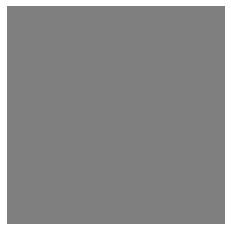

In [28]:
def generate_images(r=1,c=1,train_dim=100,is_norm=False):
  for i in range(1,1+r*c):
    noise = tf.random.normal([1,train_dim])
    plt.subplot(r,c,i)
    if is_norm:
      plt.imshow(generator(noise)[0,:,:,:]*255)
    else:
      plt.imshow(generator(noise)[0,:,:,:]*0.5 + 0.5)
    plt.axis('off')
generate_images()

In [29]:
generator = tutorial_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)

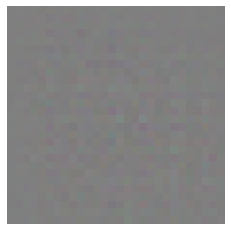

In [31]:
generate_images()

## Discriminator 
takes (256,256,3) image and gives bool(0/1) output,predicting whether input_image is fake or real

In [33]:
def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=[256,256,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(filters=128,kernel_size=(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model


In [34]:
def tutorial_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=[28,28,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(filters=128,kernel_size=(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model


In [35]:
discriminator = tutorial_discriminator_model()
gen_pred = discriminator(generated_image,training=False)
gen_pred

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00049101]], dtype=float32)>

## defining loss and optimizations

In [36]:
cross_entropy_loss = keras.losses.BinaryCrossentropy(from_logits=True)

In [37]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

training step and training loop

In [38]:
@tf.function
def train_step(image_batch,train_dim):
  noise = tf.random.normal([1,train_dim])
  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    generated_image = generator(noise,training=True) 
    discriminator_pred_gen = discriminator(generated_image,training=True)
    discriminator_pred_ori = discriminator(image_batch,training=True)

    # discriminator_loss = cross_entropy_loss(tf.ones_like(discriminator_pred_ori),discriminator_pred_ori)+
    # 尼玛的什么东西，那么大一长串
    discriminator_loss = cross_entropy_loss(tf.ones_like(discriminator_pred_ori),discriminator_pred_ori) + cross_entropy_loss(tf.zeros_like(discriminator_pred_gen), discriminator_pred_gen)
    generator_loss = cross_entropy_loss(tf.ones_like(discriminator_pred_gen),discriminator_pred_gen)

  # gradient
  generator_grad = gen_tape.gradient(generator_loss,generator.trainable_variables)
  discriminator_grad = disc_tape.gradient(discriminator_loss,discriminator.trainable_variables)

  # optimizer
  generator_optimizer.apply_gradients(zip(generator_grad,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_grad,discriminator.trainable_variables))
  


In [42]:
def train(dataset,epochs,train_dim=100):
  for epoch in range(epochs):
    start = time.time()
    for image_path in dataset:
      train_step(image_path,train_dim)
    print(f'Epoch :{epoch+1} is cost {time.time()-start}')

In [43]:
normalization_layer = keras.layers.Rescaling(1./255)

In [ ]:
EPOCHS = 50 
generator = generator_model()
discriminator = discriminator_model()
train(monet_ds,EPOCHS)

Epoch :1 is cost 162.94909691810608
Epoch :2 is cost 164.15992546081543
Epoch :3 is cost 161.59211802482605
Epoch :4 is cost 162.45688581466675
Epoch :5 is cost 160.37321710586548
Epoch :6 is cost 162.81824660301208
Epoch :7 is cost 160.32869458198547
Epoch :8 is cost 162.74596786499023
Epoch :9 is cost 174.37844038009644
Epoch :10 is cost 225.409170627594
Epoch :11 is cost 233.9749939441681
Epoch :12 is cost 241.14538741111755
Epoch :13 is cost 195.2188756465912
Epoch :14 is cost 225.47992706298828
Epoch :15 is cost 205.49246978759766
Epoch :16 is cost 169.26904726028442
Epoch :17 is cost 165.25217843055725
Epoch :18 is cost 158.86444520950317
Epoch :19 is cost 157.7282702922821
Epoch :20 is cost 157.72045493125916
Epoch :21 is cost 162.05602645874023
Epoch :22 is cost 158.18434691429138
Epoch :23 is cost 157.31903958320618
Epoch :24 is cost 158.58089303970337


In [ ]:
generate_images()

In [ ]:
generate_images(5,5)

In [ ]:
monet_ds_norm = monet_ds.map(lambda x:normalization_layer(x))

In [ ]:
EPOCHS =50
generator = generator_model()
discriminator = discriminator_model()
train(monet_ds_norm,EPOCHS)

In [ ]:
generate_images(1,1,is_norm=True)

In [ ]:
tutorial_ds_norm = tutorial_ds.map(lambda x:normalization_layer(x))

rewrite the train_step() function to retrain anther model of different dimensions without making `tf.config.run_functions_eagerly(True)` and losing performance

In [ ]:
@tf.function
def train_step(image_batch,train_dim): 
  noise = tf.random.normal([1,train_dim])
  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    generated_image = generator(noise,training=True)
    discriminator_pred_gen = discriminator(generated_image,training=True)

    discriminator_pred_ori = discriminator(image_batch,training=True)
    discriminator_loss = cross_entropy_loss(tf.ones_like(discriminator_pred_ori),discriminator_pred_ori)+cross_entropy_loss(tf.zeros_like(discriminator_pred_gen),discriminator_pred_gen)
    generator_loss= cross_entropy_loss(tf.ones_like(discriminator_pred_gen),discriminator_pred_gen)
  generator_grad = gen_tape.gradient(generator_loss,generator.trainable_variables)
  discriminator_grad = disc_tape.gradient(discriminator_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_grad,generator.trianable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_grad,discriminator.trainable_variables))

def train(dataset,epochs,train_dim=100):
  for epoch in range(epochs): 
    start = time.time()    
    for image_batch in dataset:
      train_step(image_batch, train_dim)
        
    print(f"Time for epoch {epoch+ 1} is : {time.time()-start}")


In [ ]:
EPOCHS= 50
generator= tutorial_generator_model()
discriminator = tutorial_discriminator_model()

train(tutorial_ds,EPOCHS)

In [ ]:
generate_images(1,1)

In [ ]:
generate_images(3,3)


In [ ]:
EPOCHS= 50
generator= tutorial_generator_model()
discriminator = tutorial_discriminator_model()
train(tutorial_ds_norm,EPOCHS)

In [ ]:
generate_images(1,1)

In [ ]:
generate_images(3,3)


In [ ]:
def updated_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(4*4*128,use_bias=False,input_shape=(128,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(layers.Reshape((4,4,128)))

  initializer = tf.random_normal_initializer(0.,0.02)
  
  model.add(layers.Conv2DTranspose(128,4, strides=(2,2), padding= 'same', kernel_initializer= initializer, use_bias= False))
  model.add(layers.BarchNormalization())
  model.add(layers.LeakyReLU())


  initializer = tf.random_normal_initializer(0.,0.02)
  model.add(layers.Conv2DTranspose(128,4, strides=(2,2), padding= 'same', kernel_initializer= initializer, use_bias= False))
  model.add(layers.BarchNormalization())
  model.add(layers.LeakyReLU())
  
  initializer = tf.random_normal_initializer(0.,0.02)
  model.add(layers.Conv2DTranspose(128//2,4, strides=(2,2), padding= 'same', kernel_initializer= initializer, use_bias= False))
  model.add(layers.BarchNormalization())
  model.add(layers.LeakyReLU())

  initializer = tf.random_normal_initializer(0.,0.02)
  model.add(layers.Conv2DTranspose(128//4,4, strides=(2,2), padding= 'same', kernel_initializer= initializer, use_bias= False))
  model.add(layers.BarchNormalization())
  model.add(layers.LeakyReLU()

  initializer = tf.random_normal_initializer(0.,0.02)
  model.add(layers.Conv2DTranspose(128//8,4, strides=(2,2), padding= 'same', kernel_initializer= initializer, use_bias= False))
  model.add(layers.BarchNormalization())
  model.add(layers.LeakyReLU()

  initializer = tf.random_normal_initializer(0.,0.02)
  model.add(layers.Conv2DTranspose(3,4, strides=(2,2), padding= 'same', kernel_initializer= initializer, use_bias= False,activation='tanh'))
  model.add(layers.BarchNormalization())
  model.add(layers.LeakyReLU()

  return model 



In [ ]:
noise = tf.random.normal([1,128])
generator = updated_generator_model()
generated_image = generator(noise,training=False)

In [ ]:
generate_images(1,1)


In [ ]:
 generate_images(3,3)


In [ ]:
def updated_discriminator_model():
  model = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0.,0.02)
  model.add(layers.Conv2D(64,4,strides=(2,2),padding='same',kernel_intializer=initalizer,input_shape=[256,256,3],use_bias=False))
  model.add(layers.LeaklyReLU())
  model.add(layers.Dropout(0.3))

  initializer = tf.random_normal_initializer(0.,0.02)
  model.add(layers.Conv2D(128,4,strides=(2,2),padding='same',kernel_iniitalizer=initializer,use_bias=False))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  initializer = tf.random_normal_initializer(0.,0.02)
  model.add(layers.Conv2D(256,4,strides=(2,2),padding='same',kernel_intializer=initializer,use_bias=False)
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.ZeroPadding2D())
  initializer = tf.random_normal_initializer(0.,0.02)

  model.add(layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,use_bias=False))
  model.add(layers.LeakyReLU())
  model.add(layers.ZeroPadding2D())

  model.add(layers.Conv2D(1,4,strides=1,kernel_initializer=initializer,use_bias=False))
  model.add(layers.LeakyReLU())
  model.add(layers.Dense(1,activation='sigmoid'))
  return model 

In [ ]:
discriminator = updated_discriminator_model()
preds = discriminator(generated_image, training=False)
print(preds)

In [ ]:
generator = updated_generator_model()
discriminator = updated_discriminator_model()

## Re-executing same train_step functions for issue already mentioned above.¶
> TMD玩我啊？

In [ ]:
# @tf.function
# def train_step(image_batch,train_dim):
#   noise = tf.random.normal([1,train_dim])
#   with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
#     generated_image = generator(noise,training=True) 
#     discriminator_pred_gen = discriminator(generated_image,training=True)
#     discriminator_pred_ori = discriminator(image_batch,training=True)

#     # discriminator_loss = cross_entropy_loss(tf.ones_like(discriminator_pred_ori),discriminator_pred_ori)+
#     # 尼玛的什么东西，那么大一长串
#     discriminator_loss = cross_entropy_loss(tf.ones_like(discriminator_pred_ori),discriminator_pred_ori) + cross_entropy_loss(tf.zeros_like(discriminator_pred_gen), discriminator_pred_gen)
#     generator_loss = cross_entropy_loss(tf.ones_like(discriminator_pred_gen),discriminator_pred_gen)

#   # gradient
#   generator_grad = gen_tape.gradient(generator_loss,generator.trainable_variables)
#   discriminator_grad = disc_tape.gradient(discriminator_loss,discriminator.trainable_variables)

#   # optimizer
#   generator_optimizer.apply_gradients(zip(generator_grad,generator.trainable_variables))
#   discriminator_optimizer.apply_gradients(zip(discriminator_grad,discriminator.trainable_variables))
  
# 和上面是一样的，没区别
EPOCHS= 50
TRAIN_DIM= 128
cross_entropy_loss = keras.losses.BinaryCrossentropy()
train(monet_ds,EPOCHS, TRAIN_DIM)


In [ ]:
generate_images(1,1, TRAIN_DIM)


In [ ]:
generate_images(3,3, TRAIN_DIM)
